lien vers le projet overleaf : https://www.overleaf.com/5941482485srsmdsjvhkch

## Partie 2

### Question 6

#### Résolution

In [56]:
from casadi import *
import numpy as np
import matplotlib.pyplot as plt

In [115]:
# constantes du problèmes 

t0 = 23
deltaT= 0.5
T_m = 18 # unité : °C
T_M = 30 # unité : °C
T_in = 18 # unité : °C
ccr = 1
cpl = 3/2
h = 0.05 # unité : h-1
k = 0.01 # unité : h-1
b = 1/500 # unité : CW-1h-1
P_M = 5000 # unité : W

In [109]:
# Construction du vecteur coût

# heures pleines
c = np.array([cpl for i in range(48)])

# heures creuses
for i in range (2,2+6*2): 
    c[i] = ccr
for i in range (26,30):
    c[i] = ccr
    
c = np.concatenate((c,np.zeros(48)))

# liste des indices des heures de présence
I_occ = np.array([16,17,18,19,38,39,40,41,42,43,44,45,46,47])

# Construction du vecteur temps
t = np.array([(t0+i*deltaT)%24 for i in range (48)])

# Construction du vecteur température extérieure (évoluant avec le temps)
Text = np.array([4+8*np.exp(-(t[i]-12)**2/40) for i in range (48)])

In [110]:
def Temp(P) :
    """
    entrée : puissance
    sortie : température
    """
    T = np.zeros(48)
    T[0] = T_in
    for i in range (1,48) :
        T[i]= np.exp(-(k+h)*deltaT)*T[i-1]+(1-np.exp(-(k+h)*deltaT))/(k+h)*(b*P[i-1]+h*Text[i-1])
    return T

def f(x) :
    return deltaT*np.dot(c,x)

In [111]:

opti = casadi.Opti();
n = 96 # nombre de temps de calcul
x = opti.variable(n)

# Construction de la fonction f à minimiser

f = 0
for i in range (n-1):
    f += deltaT*c[i]*x[i]
opti.minimize(f)

# Construction des contraintes 
for i in range (48):
    opti.subject_to(-x[i]<=0)
    opti.subject_to(x[i]-P_M<=0)
for i in I_occ :
    opti.subject_to(T_m-x[48+i]<=0)
    opti.subject_to(-T_M+x[48+i]<=0)
opti.subject_to(x[47]==0)
opti.subject_to(x[48]-T_in==0)
for i in range (1,48) :
    opti.subject_to(
        x[48+i]-(np.exp(-(k+h)*deltaT)*x[48+i-1]+(1-np.exp(-(k+h)*deltaT))/(k+h)*(b*x[i-1]+h*Text[i-1]))==0)

# Calcul
x0 = np.concatenate((np.array([25. for i in range (48)]),np.array([2500. for i in range(48)]))) # initialisation
opti.set_initial(x,x0)
opti.solver('ipopt') # choix de la méthode de résolution
sol = opti.solve()
X=sol.value(x) # récupération du vecteur recherché

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      143
Number of nonzeros in inequality constraint Jacobian.:      124
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       96
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       49
Total number of inequality constraints...............:      124
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      124

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

#### Tracé du profil de température

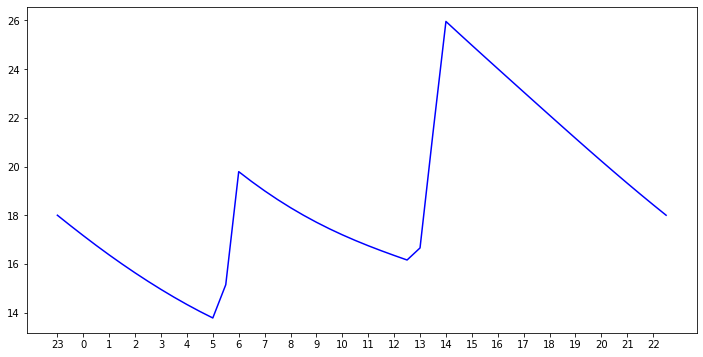

In [112]:
hour = np.concatenate((np.array([int(23)]),range(23)))
hour_place = np.linspace(0,46,24,2)

plt.figure(figsize=(12, 6))
plt.plot(range(48),X[48:],'b', label ='température habitat')
plt.xticks(hour_place,hour)
plt.show()

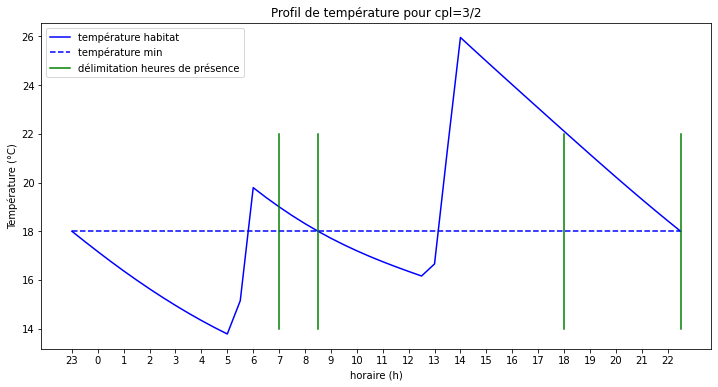

In [113]:
hour = np.concatenate((np.array([int(23)]),range(23)))
hour_place = np.linspace(0,46,24,2)

plt.figure(figsize=(12, 6))
plt.plot(range(48),X[48:],'b', label ='température habitat')
plt.xticks(hour_place,hour)

plt.plot(range(48), np.array([T_m for i in range (48)]),'b--', label = 'température min')
#plt.plot(range(48),np.array([T_M for i in range (48)]),'r')

plt.plot(np.array([16 for i in range(48)]), np.linspace(14,22,48),'g',label = 'délimitation heures de présence')
plt.plot(np.array([19 for i in range(48)]), np.linspace(14,22,48),'g')
plt.plot(np.array([38 for i in range(48)]), np.linspace(14,22,48),'g')
plt.plot(np.array([47 for i in range(48)]), np.linspace(14,22,48),'g')


legend = plt.legend(loc='upper left')
plt.ylabel('Température (°C)')
plt.xlabel('horaire (h)') # à modifier pour que ce soit effectivement les horaires
plt.title('Profil de température pour cpl=3/2')
plt.show()

#### Tracé du profil de puissance

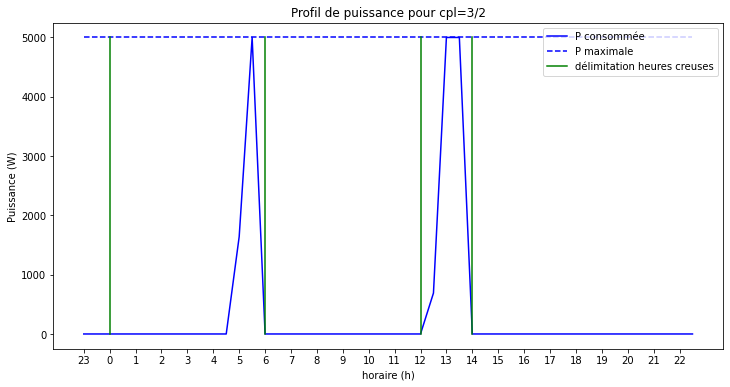

In [114]:
plt.figure(figsize=(12, 6))
plt.plot(range(48),X[:48],'b',label = 'P consommée')
plt.xticks(hour_place,hour)


plt.plot(range(48), np.array([P_M for i in range (48)]),'b--',label = 'P maximale ')
#plt.plot(range(48),np.array([T_M for i in range (48)]),'r')
plt.plot(np.array([2 for i in range(48)]), np.linspace(0,5000,48),'g',label = 'délimitation heures creuses')
plt.plot(np.array([14 for i in range(48)]), np.linspace(0,5000,48),'g')
plt.plot(np.array([26 for i in range(48)]), np.linspace(0,5000,48),'g')
plt.plot(np.array([30 for i in range(48)]), np.linspace(0,5000,48),'g')

legend = plt.legend(loc='upper right')
plt.ylabel('Puissance (W)')
plt.xlabel('horaire (h)') # à modifier pour que ce soit effectivement les horaires
plt.title('Profil de puissance pour cpl=3/2')
plt.show()

# Partie 3 - Régulation collective

### Question 8 

#### Résolution

In [99]:
# constantes du problèmes 

t0 = 23
deltaT= 0.5
T_m1 = 18 # unité : °C
T_M1 = 30 # unité : °C
T_m2 = 20 # unité : °C
T_M2 = 30 # unité : °C
T_in = 18 # unité : °C

ccr = 1
cpl = 3/2

h = 0.05 # unité : h-1
k = 0.01 # unité : h-1
b = 1/500 # unité : CW-1h-1
P_M = 5000 # unité : W

# Construction du vecteur coût 

# heures pleines
c = np.array([cpl for i in range(48)])

# heures creuses
for i in range (2,2+6*2):
    c[i] = ccr
for i in range (26,30):
    c[i] = ccr
c = np.concatenate((c,c))
c= np.concatenate((c,np.zeros(48*2)))

I_occ = np.array([16,17,18,19,38,39,40,41,42,43,44,45,46,47])
t = np.array([(t0+i*deltaT)%24 for i in range (48)])
Text = np.array([4+8*np.exp(-(t[i]-12)**2/40) for i in range (48)])

In [100]:
opti = casadi.Opti();
n = 96*2
x = opti.variable(n)

# fonction f à minimiser
f = 0
for i in range (n-1):
    f += deltaT*c[i]*x[i]
opti.minimize(f)

# contraintes
for i in range (96):
    opti.subject_to(-x[i]<=0)
    opti.subject_to(x[i]-P_M<=0)
for i in I_occ :
    opti.subject_to(T_m1-x[96+i]<=0)
    opti.subject_to(-T_M1+x[96+i]<=0)
    opti.subject_to(T_m2-x[144+i]<=0)
    opti.subject_to(-T_M2+x[144+i]<=0)
opti.subject_to(x[47]==0)
opti.subject_to(x[95]==0)
opti.subject_to(x[96]-T_in==0)
opti.subject_to(x[144]-T_in==0)
for i in range (1,48) :
    opti.subject_to(
        x[96+i]-(np.exp(-(k+h+h)*deltaT)*x[96+i-1]+(1-np.exp(-(k+h+h)*deltaT))/(k+h+h)*(b*x[i-1]+h*Text[i-1]+h*x[144+i]))==0)
    opti.subject_to(
        x[144+i]-(np.exp(-(k+h+h)*deltaT)*x[144+i-1]+(1-np.exp(-(k+h+h)*deltaT))/(k+h+h)*(b*x[48+i-1]+h*Text[i-1]+h*x[96+i]))==0)

x0 = np.concatenate((np.array([25. for i in range (96)]),np.array([2500. for i in range(96)]))) # initialisation

# calcul
opti.set_initial(x,x0)
opti.solver('ipopt')
sol = opti.solve()
X=sol.value(x)
T1 = X[96:144]
T2 = X[144:]

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      380
Number of nonzeros in inequality constraint Jacobian.:      248
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      192
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       98
Total number of inequality constraints...............:      248
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      248

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

#### Tracé des profils de température

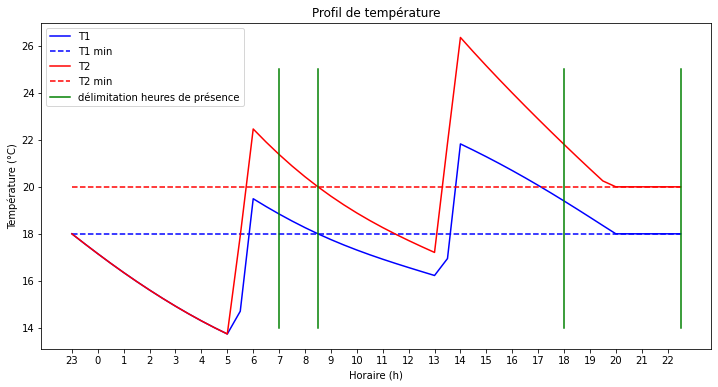

In [101]:
plt.figure(figsize=(12, 6))
plt.xticks(hour_place,hour)

plt.plot(range(48),T1,'b', label = 'T1')
plt.plot(range(48), np.array([T_m1 for i in range (48)]),'b--',label = 'T1 min')

plt.plot(range(48),T2,'r', label = 'T2')
plt.plot(range(48), np.array([T_m2 for i in range (48)]),'r--',label = 'T2 min')

#plt.plot(range(48),np.array([T_M for i in range (48)]),'r')
plt.plot(np.array([16 for i in range(48)]), np.linspace(14,25,48),'g', label = 'délimitation heures de présence' )
plt.plot(np.array([19 for i in range(48)]), np.linspace(14,25,48),'g')
plt.plot(np.array([38 for i in range(48)]), np.linspace(14,25,48),'g')
plt.plot(np.array([47 for i in range(48)]), np.linspace(14,25,48),'g')

legend = plt.legend(loc = "upper left")      
plt.xlabel('Horaire (h)')
plt.ylabel('Température (°C)')
plt.title('Profil de température')
plt.show()

#### Tracé des profils de puissance

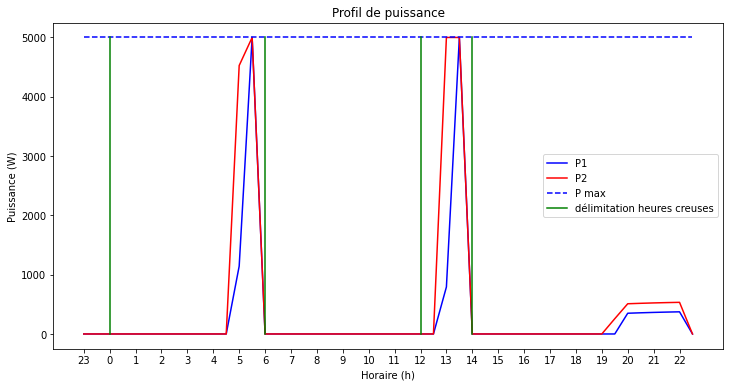

In [106]:
plt.figure(figsize=(12, 6))
plt.xticks(hour_place,hour)

plt.plot(range(48),X[:48],'b', label = 'P1')
plt.plot(range(48),X[48:96],'r', label = 'P2')

plt.plot(range(48), np.array([P_M for i in range (48)]),'b--', label = 'P max')
#plt.plot(range(48),np.array([T_M for i in range (48)]),'r')
plt.plot(np.array([2 for i in range(48)]), np.linspace(0,5000,48),'g',label = 'délimitation heures creuses')
plt.plot(np.array([14 for i in range(48)]), np.linspace(0,5000,48),'g')
plt.plot(np.array([26 for i in range(48)]), np.linspace(0,5000,48),'g')
plt.plot(np.array([30 for i in range(48)]), np.linspace(0,5000,48),'g')

legend = plt.legend(loc = "center right")      
plt.xlabel('Horaire (h)')
plt.ylabel('Puissance (W)')
plt.title('Profil de puissance')
plt.show()

### Question 9

## V1 : résolution avec ajout d'un terme quadratique

In [107]:
eps = 0.01
rho = 0.001
Niter = 50
n = 48

# construction du vecteur coût
c = np.array([cpl for i in range(n)]) # heures pleines

# heures creuses
for i in range (2,2+6*2):
    c[i] = ccr
for i in range (26,30):
    c[i] = ccr
c= np.concatenate((c,np.zeros(n)))

# initialisation de lambda utilisé dans le lagrangien
lambdak = np.ones((2*n+2*(n+1)+2*len(I_occ)))
lambdak1 = np.ones((2*n+2*(n+1)+2*len(I_occ)))
k=0

while (np.linalg.norm(lambdak1 - lambdak)>eps or k ==0) and k+1<Niter :
    k+=1
   
    lambdak = np.copy(lambdak1)
    
    # résolution pour l'habitat 1
    
    x = opti.variable(2*n) # variable de décision pour l'habitat 1

    f1 = 0
    for i in range (n):
        f1 += deltaT*c[i]*x[i]+eps*(x[i]**2+x[n+i]**2)
    for i in range (len(c1(x))) :
        f1 += lambdak[i]*c1(x)[i]
    opti.minimize(f1)    

    opti.subject_to()
    x0 = np.concatenate((np.array([2500. for i in range(n)]),np.array([T_in for i in range (n)])))
    opti.set_initial(x,x0)
    opti.solver('ipopt')
    sol = opti.solve()
    x = sol.value(x)
    
    # idem pour l'habitat 2
    
    y = opti.variable(2*n) # variable de décision pour l'habitat 2

    f2 = 0
    for i in range (n):
        f2 += deltaT*c[i]*y[i]+eps*(y[i]**2+y[n+i]**2)
    for i in range (len(c2(y))) :
        f2 += lambdak[i]*c2(y)[i]
    opti.minimize(f2)    

    opti.subject_to()
    x0 = np.concatenate((np.array([2500. for i in range(n)]),np.array([T_in for i in range (n)])))
    opti.set_initial(y,x0)
    opti.solver('ipopt')
    sol = opti.solve()
    y = sol.value(y)
          
    for i in range (len(lambdak)): # mise à jour du multiplicateur de Lagrande
        lambdak1[i]=max(0,lambdak[i]+rho*(c1(x)[i]+c2(y)[i]))

NameError: name 'c1' is not defined

#### Tracé des profils de puissance

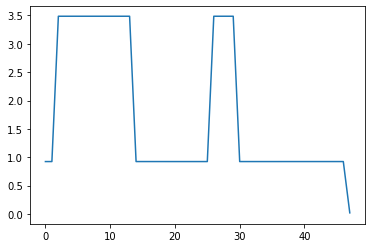

In [81]:
plt.plot(range(48), x[:48],'b', label = 'P1')
plt.plot(range(48), y[:48],'r',label = 'P2')

plt.plot(range(48), np.array([P_M for i in range (48)]),'b--', label = 'P max')
plt.plot(np.array([2 for i in range(48)]), np.linspace(0,0.001,48),'g',label = 'délimitation heures creuses')
plt.plot(np.array([14 for i in range(48)]), np.linspace(0,0.001,48),'g')
plt.plot(np.array([26 for i in range(48)]), np.linspace(0,0.001,48),'g')
plt.plot(np.array([30 for i in range(48)]), np.linspace(0,0.001,48),'g')

legend = plt.legend(loc = "lower left")      
plt.xlabel('Horaire (h)')
plt.ylabel('Puissance (W)')
plt.title('Profil de puissance')
plt.show()

#### Tracé des profils de température

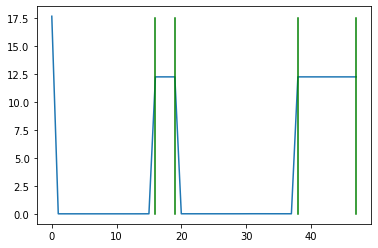

In [83]:
plt.plot(range(48), x[48:],'b',label = 'T1')
plt.plot(range(48), np.array([T_m1 for i in range (48)]),'b--',label = 'T1 min')

plt.plot(range(48), y[48:],'r', label = 'T2')
plt.plot(range(48), np.array([T_m2 for i in range (48)]),'r--',label = 'T2 min')

plt.plot(np.array([16 for i in range(48)]), np.linspace(0,17.5,48),'g', label = 'délimitation heures de présence' )
plt.plot(np.array([19 for i in range(48)]), np.linspace(0,17.5,48),'g')
plt.plot(np.array([38 for i in range(48)]), np.linspace(0,17.5,48),'g')
plt.plot(np.array([47 for i in range(48)]), np.linspace(0,17.5,48),'g')

legend = plt.legend(loc = "upper left")      
plt.xlabel('Horaire (h)')
plt.ylabel('Température (°C)')
plt.title('Profil de température')
plt.show()

## V2 : résolution avec décomposition uniquement des contraintes "mixtes"

In [15]:
def c1(x) :
    '''contraintes sur le vecteur x relatif à l habitation 1 '''
    c1 = []
    #contraintes égalités
    c1 += [x[n-1]]
    c1 +=[-x[n-1]]
    c1 += [x[n]-T_in]
    c1 += [-(x[n]-T_in)]
    
    for i in range (1,n):
        c1 +=[np.exp(-(k+h+h)*deltaT)*x[n+i-1]
              +(1-np.exp(-(k+h+h)*deltaT))/(k+h+h)*(b*x[i-1]+h*Text[i-1]+h*T2[i-1])-x[n+i]]
        
    for i in range (4,len(c1)):
        c1 += [-c1[i]]
    
    #contraintes inégalités 
    for i in range (n):
        c1+=[-x[i]]
        c1+=[x[i]-P_M]
        
    for i in I_occ :
        c1+=[T_m1-x[n+i]]
        c1+=[-T_M1+x[n+i]]
    return c1

def c2 (y):
    '''contraintes sur le vecteur y relatif à l habitation 2 '''
    c2 = []
    #contraintes égalités
    c2 += [y[n-1]]
    c2 += [y[n]-T_in]
    c2 += [-y[n-1]]
    c2 += [-(y[n]-T_in)]
    for i in range (1,n):
        c2 +=[np.exp(-(k+h+h)*deltaT)*y[n+i-1]
              +(1-np.exp(-(k+h+h)*deltaT))/(k+h+h)*(b*y[i-1]+h*Text[i-1]+h*T1[i-1])-y[n+i]]
    for i in range (4,len(c2)):
        c2 += [-c2[i]]

    #contraintes inégalités 
    for i in range (n):
        c2+=[-y[i]]
        c2+=[y[i]-P_M]
    for i in I_occ :
        c2+=[T_m2-y[n+i]]
        c2+=[-T_M2+y[n+i]]
    return c2

In [16]:
def c1J(x) :
    '''construction des ensembles I et J (notations utilisées sur votre remarque Moodle'''
    c1 = []
    #contraintes égalités
    c1 += [x[n-1]]
    c1 +=[-x[n-1]]
    c1 += [x[n]-T_in]
    c1 += [-(x[n]-T_in)]
    J = [i for i in range(4)]
    I =[]
    
    for i in range (1,n):
        c1 +=[np.exp(-(k+h+h)*deltaT)*x[n+i-1]
              +(1-np.exp(-(k+h+h)*deltaT))/(k+h+h)*(b*x[i-1]+h*Text[i-1]+h*T2[i-1])-x[n+i]]
        I +=[len(c1)-1]
    for i in range (4,len(c1)):
        c1 += [-c1[i]]
        I +=[len(c1)-1]

    #contraintes inégalités 
    for i in range (n):
        c1+=[-x[i]]
        J+=[len(c1)-1]
        c1+=[x[i]-P_M]
        J+=[len(c1)-1]
    for i in I_occ :
        c1+=[T_m1-x[n+i]]
        J+=[len(c1)-1]
        c1+=[-T_M1+x[n+i]]
        J+=[len(c1)-1]
    return I,J

calIJ = np.zeros(2*n)
I, J = c1J(calIJ)

In [19]:
eps = 0.01
rho = 0.1
Niter = 40
n = 48

# construction du vecteur coût 

c = np.array([cpl for i in range(n)]) # heures pleines

# heures creuses
for i in range (2,2+6*2):
    c[i] = ccr
for i in range (26,30):
    c[i] = ccr
c= np.concatenate((c,np.zeros(n)))

# initialisation du multiplicateur de Lagrange
lambdak = np.ones((2*n+2*(n+1)+2*len(I_occ)))
lambdak1 = np.ones((2*n+2*(n+1)+2*len(I_occ)))
k=0

while (np.linalg.norm(lambdak1 - lambdak)>eps or k ==0) and k+1<Niter :
    k+=1
    lambdak = np.copy(lambdak1)
    
    # résolution pour l'habitat 1
    x = opti.variable(2*n)
        
    f1 = 0
    for i in range (n):
        f1 += deltaT*c[i]*x[i]+eps*x[i]**2
    for i in I : # uniquement pour i dans I
        f1 += lambdak[i]*c1(x)[i]
    opti.minimize(f1)    
    
    for i in J: # uniquement pour i dans J
        opti.subject_to(c1(x)[i]<=0)

    x0 = np.concatenate((np.array([2500. for i in range(n)]),np.array([T_in for i in range (n)])))
    opti.set_initial(x,x0)
    opti.solver('ipopt')
    sol = opti.solve()
    x = sol.value(x)
    
    # résolution pour l'habitat 1
    y = opti.variable(2*n)
    
    f2 = 0
    for i in range (n):
        f2 += deltaT*c[i]*y[i]+eps*y[i]**2
    for i in I :
        f2 += lambdak[i]*c2(y)[i]
    opti.minimize(f2)    

    for i in J:
        opti.subject_to(c2(y)[i]<=0)
    
    x0 = np.concatenate((np.array([2500. for i in range(n)]),np.array([T_in for i in range (n)])))
    opti.set_initial(y,x0)
    opti.solver('ipopt')
    sol = opti.solve()
    y = sol.value(y)
          
    for i in I:
        lambdak1[i]=max(0,lambdak[i]+rho*(c1(x)[i]+c2(y)[i]))
    
print(f"k vaut {k}")


1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      380
Number of nonzeros in inequality constraint Jacobian.:     1144
Number of nonzeros in Lagrangian Hessian.............:       48

Total number of variables............................:      864
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       98
Total number of inequality constraints...............:     1144
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:     1144

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0

 y est [-7.13611022e-09 -7.13611022e-09 -4.98819288e-09 -4.98819288e-09
 -4.98819288e-09 -4.98819288e-09 -4.98819288e-09 -4.98819288e-09
 -4.98819288e-09 -4.98819288e-09 -4.98819288e-09 -4.98819288e-09
 -4.98819288e-09 -4.98819288e-09 -7.13611022e-09 -7.13611022e-09
 -7.13611022e-09 -7.13611022e-09 -7.13611022e-09 -7.13611022e-09
 -7.13611022e-09 -7.13611022e-09 -7.13611022e-09 -7.13611022e-09
 -7.13611022e-09 -7.13611022e-09 -4.98819288e-09 -4.98819288e-09
 -4.98819288e-09 -4.98819288e-09 -7.13611022e-09 -7.13611022e-09
 -7.13611022e-09 -7.13611022e-09 -7.13611022e-09 -7.13611022e-09
 -7.13611022e-09 -7.13611022e-09 -7.13611022e-09 -7.13611022e-09
 -7.13611022e-09 -7.13611022e-09 -7.13611022e-09 -7.13611022e-09
 -7.13611022e-09 -7.13611022e-09 -7.13611022e-09 -6.10626383e-09
  1.80000000e+01  1.80000000e+01  1.80000000e+01  1.80000000e+01
  1.80000000e+01  1.80000000e+01  1.80000000e+01  1.80000000e+01
  1.80000000e+01  1.80000000e+01  1.80000000e+01  1.80000000e+01
  1.80000000e+01  

RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:159:
.../casadi/core/optistack_internal.cpp:999: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Diverging_Iterates'